In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Data/UIT-ISE Dataset.zip"

Archive:  /content/drive/MyDrive/Data/UIT-ISE Dataset.zip
   creating: UIT-ISE Dataset/.ipynb_checkpoints/
  inflating: UIT-ISE Dataset/ise-dsc01-warmup.json  
  inflating: UIT-ISE Dataset/ise-dsc01-public-test-offcial.json  
  inflating: UIT-ISE Dataset/public_result.json  
  inflating: UIT-ISE Dataset/ise-dsc01-train.json  


In [3]:
# For read excel format form pandas
!pip install openpyxl

In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [5]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 3
N_SPLITS = 5

In [6]:
import json

train_path = '/content/UIT-ISE Dataset/ise-dsc01-train.json'
with open(train_path, 'r') as file:
    data = json.load(file)

import pandas as pd
df = pd.DataFrame.from_dict(data, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'id'}, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [8]:
def get_data(df):
    df = df[['context','domain']]
    return df

train_df = get_data(train_df)
valid_df = get_data(val_df)
test_df = get_data(test_df)

# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.domain)):
    train_df.loc[val_, "kfold"] = fold

In [9]:
train_df.sample(5)

,context,domain,kfold
28694,Mảnh thiên thạch thường bắt nguồn từ tiểu hành...,khoa-hoc,4.0
5844,Bà Tư là chủ cơ sở thu mua hải sản Nam Tư đóng...,thoi-su,0.0
18534,"Ngày 26/9, lãnh đạo Cục An toàn lao động cho b...",thoi-su,3.0
21187,"Trong công điện ban hành tối 4/5, Thủ tướng Ph...",thoi-su,3.0
23885,Ba độc giả trúng thưởng gồm: Vũ Thị Mai Anh (m...,khoa-hoc,3.0


In [10]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30373 entries, 0 to 30372
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   context  30373 non-null  object 
 1   domain   30373 non-null  object 
 2   kfold    30373 non-null  float64
dtypes: float64(1), object(2)
memory usage: 712.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7594 entries, 19775 to 30643
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   context  7594 non-null   object
 1   domain   7594 non-null   object
dtypes: object(2)
memory usage: 178.0+ KB


(None, None)

**=> No Missing Values**

<Axes: xlabel='domain', ylabel='count'>

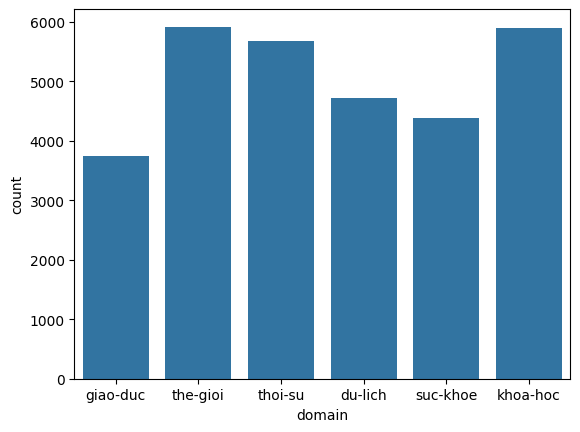

In [11]:
sns.countplot(x='domain', data=train_df)

In [12]:
train_df.domain.unique()

array(['giao-duc', 'the-gioi', 'thoi-su', 'du-lich', 'suc-khoe',
       'khoa-hoc'], dtype=object)

In [13]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [14]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='giao-duc':
            return 0
        elif text=='the-gioi':
            return 1
        elif text=='thoi-su':
            return 2
        elif text=='du-lich':
            return 3
        elif text=='suc-khoe':
            return 4
        elif text=='khoa-hoc':
            return 5

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['context']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['domain'])

        return text, label

In [15]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [16]:
from tqdm import tqdm
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

    for i, data in progress_bar:
        # input_ids = inputs.to(device)
        # attention_mask = attention_mask.to(device)
        # targets = labels.to(device)
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))

        for i, data in progress_bar:
            # input_ids = inputs.to(device)
            # attention_mask = attention_mask.to(device)
            # targets = labels.to(device)
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


In [17]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=128)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=128)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [18]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'/content/UIT-ISE Dataset/phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1/3
------------------------------


100%|██████████| 760/760 [08:31<00:00,  1.49it/s]

Train Accuracy: 0.9018026174993826 Loss: 0.3669160545472742



100%|██████████| 190/190 [00:42<00:00,  4.45it/s]


Valid Accuracy: 0.9835390946502058 Loss: 0.07291699686136685
Epoch 2/3
------------------------------


100%|██████████| 760/760 [08:36<00:00,  1.47it/s]

Train Accuracy: 0.9898345542843032 Loss: 0.046869585268493545



100%|██████████| 190/190 [00:42<00:00,  4.42it/s]


Valid Accuracy: 0.9965432098765433 Loss: 0.02174126555358893
Epoch 3/3
------------------------------


100%|██████████| 760/760 [08:36<00:00,  1.47it/s]

Train Accuracy: 0.9980656844184707 Loss: 0.011315882977214642



100%|██████████| 190/190 [00:42<00:00,  4.43it/s]


Valid Accuracy: 0.9983539094650207 Loss: 0.00976132905772446
-----------Fold: 2 ------------------
Epoch 1/3
------------------------------


100%|██████████| 760/760 [08:36<00:00,  1.47it/s]

Train Accuracy: 0.8993332784591324 Loss: 0.3766310365821578



100%|██████████| 190/190 [00:42<00:00,  4.46it/s]


Valid Accuracy: 0.97761316872428 Loss: 0.0915867026209047
Epoch 2/3
------------------------------


100%|██████████| 760/760 [08:35<00:00,  1.47it/s]

Train Accuracy: 0.9900403325376573 Loss: 0.04936612010290111



100%|██████████| 190/190 [00:42<00:00,  4.42it/s]


Valid Accuracy: 0.9935802469135804 Loss: 0.031812939965656324
Epoch 3/3
------------------------------


100%|██████████| 760/760 [08:35<00:00,  1.47it/s]

Train Accuracy: 0.9980656844184707 Loss: 0.010680334452129165



100%|██████████| 190/190 [00:43<00:00,  4.40it/s]


Valid Accuracy: 0.9968724279835391 Loss: 0.024699951585774357
-----------Fold: 3 ------------------
Epoch 1/3
------------------------------


100%|██████████| 760/760 [08:36<00:00,  1.47it/s]

Train Accuracy: 0.8963700716108322 Loss: 0.37993952364562766



100%|██████████| 190/190 [00:42<00:00,  4.45it/s]


Valid Accuracy: 0.9711934156378602 Loss: 0.11674647541520627
Epoch 2/3
------------------------------


100%|██████████| 760/760 [08:35<00:00,  1.47it/s]

Train Accuracy: 0.9883529508601531 Loss: 0.05781606643454564



100%|██████████| 190/190 [00:42<00:00,  4.46it/s]


Valid Accuracy: 0.9919341563786009 Loss: 0.04418521182930195
Epoch 3/3
------------------------------


100%|██████████| 760/760 [08:36<00:00,  1.47it/s]

Train Accuracy: 0.9962548357889538 Loss: 0.019750077270069406



100%|██████████| 190/190 [00:42<00:00,  4.46it/s]


Valid Accuracy: 0.9952263374485597 Loss: 0.029348350648988823
-----------Fold: 4 ------------------
Epoch 1/3
------------------------------


100%|██████████| 760/760 [08:35<00:00,  1.47it/s]

Train Accuracy: 0.9023828141075765 Loss: 0.3658483515861199



100%|██████████| 190/190 [00:42<00:00,  4.44it/s]


Valid Accuracy: 0.9827132038195587 Loss: 0.08356371207260772
Epoch 2/3
------------------------------


100%|██████████| 760/760 [08:36<00:00,  1.47it/s]

Train Accuracy: 0.9887238157948888 Loss: 0.05499158105782331



100%|██████████| 190/190 [00:43<00:00,  4.41it/s]


Valid Accuracy: 0.995554823839315 Loss: 0.020967199551676842
Epoch 3/3
------------------------------


100%|██████████| 760/760 [08:36<00:00,  1.47it/s]

Train Accuracy: 0.9979011481953991 Loss: 0.012555031002327603



100%|██████████| 190/190 [00:42<00:00,  4.46it/s]


Valid Accuracy: 0.9976950938426078 Loss: 0.010659640498067204
-----------Fold: 5 ------------------
Epoch 1/3
------------------------------


100%|██████████| 760/760 [08:35<00:00,  1.47it/s]

Train Accuracy: 0.8971562615745504 Loss: 0.3953865801106746



100%|██████████| 190/190 [00:42<00:00,  4.46it/s]


Valid Accuracy: 0.9753045768850839 Loss: 0.10946426716093954
Epoch 2/3
------------------------------


100%|██████████| 760/760 [08:35<00:00,  1.47it/s]

Train Accuracy: 0.987448043129347 Loss: 0.06059841748884585



100%|██████████| 190/190 [00:43<00:00,  4.32it/s]


Valid Accuracy: 0.9948962792229172 Loss: 0.03472195911760393
Epoch 3/3
------------------------------


100%|██████████| 760/760 [08:35<00:00,  1.47it/s]

Train Accuracy: 0.9975307625828224 Loss: 0.014057435330744881



100%|██████████| 190/190 [00:42<00:00,  4.46it/s]


Valid Accuracy: 0.99703654922621 Loss: 0.020693082433488025


In [21]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=6)
        model.to(device)
        model.load_state_dict(torch.load(f'/content/UIT-ISE Dataset/phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [22]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       979
           1       1.00      1.00      1.00      1485
           2       1.00      1.00      1.00      1441
           3       1.00      1.00      1.00      1164
           4       1.00      1.00      1.00      1024
           5       1.00      1.00      1.00      1501

    accuracy                           1.00      7594
   macro avg       1.00      1.00      1.00      7594
weighted avg       1.00      1.00      1.00      7594



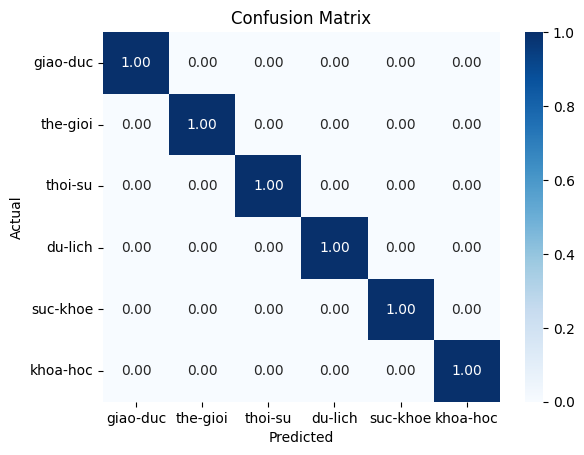

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(labels, predictions,class_names):
    cm = confusion_matrix(labels, predictions, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


class_names = ['giao-duc', 'the-gioi', 'thoi-su', 'du-lich', 'suc-khoe','khoa-hoc']
plot_confusion_matrix(real_values, predicts,class_names)

In [26]:
# def check_wrong(real_values, predicts):
#     wrong_arr = []
#     wrong_label = []
#     for i in range(len(predicts)):
#         if predicts[i] != real_values[i]:
#             wrong_arr.append(i)
#             wrong_label.append(predicts[i])
#     return wrong_arr, wrong_label

# for i in range(15):
#     print('-'*50)
#     wrong_arr, wrong_label = check_wrong(real_values, predicts)
#     print(test_df.iloc[wrong_arr[i]].context)
#     print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

In [28]:
def infer(text, tokenizer, max_len=128):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')